<a href="https://colab.research.google.com/github/zfukuoka/image_visual_analysis/blob/createLabView/image_visual_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Analysis in comparing using Gooogle Colab / Google Colaboratory用画像比較分析

This is image analysis in comparing using Google Colab.
Now, this program compares CIE 1931 xy color space, CIE L\*a\*b\* and CIE L\*C\*h between 2 images.

Google Colaboratory用の画像比較分析プログラムです。
現在は、CIE xy色度図、 L\*a\*b\*、L\*C\*h の比較表示をします。


## Requirements / 動作に必要なもの

*   Google account for use of Google Colab / Google Colaboratory を使うための Google アカウント
*   Web browther / Webブラウザ
*   2 pictures have same angle of view / 同じ画角で撮影した画像２枚


## Usage / 動作方法

This jupyter notebook has only 1 cell. So, it runs the cell and uploads 2 pictures which have same angle of view.
When upload error is occurred in specifing 2 pictures at once, please specify and upload pictures one by one.  

唯一のセルを起動後（わからなければ、メニューの「ランタイム」→「すべてのセルを実行」）、コードの後ろにある実行結果を表示ところでファイルアップロードが求められるので、２つ画像ファイルを指定して、後は待つだけ。
もし画像２つを同時指定してアップロードに失敗するようなら、一つずつ画像の指定とアップロードをしてください。


## Design concepts / 設計思想

* カメラで撮影した画像を用いて簡単に動かし、簡単な可視化（プロット表示）を重視しています
  * 一方ソースコードの見やすさの改善は今後も検討課題ですが、現時点ではあまり重視しておりません
  * 可視化時に細かな精度は必要でないと判断しているため、処理時間短縮にも寄与するように演算精度は主に32bit浮動小数点を用いています
  * 多くの点のプロットによる表示つぶれの考慮と処理時間短縮の考慮もあり、画像の長編が256ピクセル未満にデータの間引きを行って処理しています
* 動作環境は横長である程度画面の大きいPCやタブレット上で見ることを想定しています
  * 一応Androidスマートフォン上でも動作するようにChrome利用時に画像のアップロード処理を1つずつにできるように改善しています
    * PC のブラウザでは２つが画像を同時にアップロードできます
  * 利用しているPCやタブレットの画面情報取得ができないと判断しているため、縦長の画面で左右にプロットを並べた時にに見づらいままになっています
* カメラで撮影した画像を主な対象としているので、sRGB色空間とガンマ2.2を採用したのJPEGファイルのみ正しく動作します
  *  最近のiPhoneシリーズではsRGBと異なるDisplayP3色空間のため、正しく動作しません
  * ガンマ補正・ガンマの逆補正の計算には幾つかの手法があり、この手法の違いによる結果の違いが生じることはあります。なお、本ソフトウェアでは後述の式で計算しています
  * 処理自体でJPEGのみに制限はしておりませんが、他の形式の画像では正しく動作しない可能性があります
* 色の変換過程をオープンにしたいため、OpenCVやPillowなどの画像処理関係のライブラリAPIで変換処理は行っていません（但し、JPEGからRGB値取得処理除く）
  * 依存ライブラリがない代わりに変換時の演算処理は Numpy に依存しており、ある程度の処理速度を実現するために Numpy特有書き方による可読性の低いソースコードになっている部分があります
  * 依存関係が少ない分、実装量が増えることを許容しています
* 処理の基本的なところはGoogle Colaboratory に依存しない作りを目指しています
  * Python環境を新規に構築することなく簡単に使えるようしたい部分と任意の画像ファイルで利用できるように重視した結果、画像ファイルのアップロード部分のみ Google Colaboratory に依存した作りです
* CIE L\*a\*b\* 及び CIE L\*C\*h のプロットではカメラの画像を重視したので、白色点がD65で計算しています
  * 多くのCIE L\*a\*b\*では白色点にD50を用いていると考えていますが、白色点をD50にした場合、D65の白色・灰色はプロット上の原点より青っぽいところに位置し、白色・灰色に限らず他の色も違いが分かりにくいことを危惧したためし白色点にD65を採用し、白色・灰色・黒色が原点になるようにしています
  * 白色点をD65にした際に白色・灰色の (a\*, b\*) が 演算上 (-0.004, -0.008) になるため、厳密的な原点になっていません
  * 白色点をD65からD50に切り替える仕組みは入っているので、D50が良い場合はコードの変更をお願いします
* 各プロットの意図は下記の通り
  * CIE xy プロットは、 sRGB色空間全体と黒体軌跡の部分の色分布が分かりやすいように透過なしの黒でプロットしています
  * CIE xy プロットとヒストグラムは、２枚の画像の色分布違いを分かりやすくするように透過色を用いた重ねた表示にしています
  * CIE xy のヒートマッププロットは、sRGB色空間全体と黒体軌跡の部分の分布よりもどの色が多いのかを分かりやすくするようにしています
  * RGBと輝度のヒストグラムは、各々の観点で分布と２枚の画像の違いが分かりやすいようにヒストグラム、累積率、平均値をプロットしています
  * CIE L\*a\*b\* の a\*/b\* プロットは、 xyプロットとは異なる観点で色の分布が分かりやすいように透過なしの黒でプロットしています
  * CIE L\*C\*h プロットとヒストグラムは、２つの画像の色相の違いを認識易くなるよう（a\*/b\* のプロットから角度の違いは認識し難い点も考慮するよう）に色相を横軸にした２次元でプロットしています

 
## Restrictions / 制限事項

* 画像サイズが大きいと、アップロード時間が増大します
  * 本ソフトウェアではアップロード時間に寄与するところがないため、改善方法はありません
    * Google DriveやWebからのダウンロードの方が早い可能性はありますが、利用方法の限定に繋がるので導入は検討しておりません
  * 画像の間引きを行っているので、あらかじめ画質を落とさず、解像度を低く、ファイルサイズを抑制した画像を利用することをお勧めします。
* 一度アップロードした画像ファイルでも再度アップロードが必要です
  * 何百回も使い続けると、画像をアップロードによるGoogle Colaboratory上のストレージを圧迫する可能性があります
  * Google Colaboratory上のストレージの圧迫を危惧するような事態になった場合、一旦セッション（Google Colaboratory上の動作環境）を終了してから、再度起動してください。現行の振る舞いではセッション終了でストレージの中身が消えるようです
* わかりやすいプロットやグラフの完成系が見通せていないため、冗長なコードがあったり、逐次コード変更する可能性があります
* 入力した画像を表示する機能は一時的な実装で、まともな機能にする予定もなく、将来削除する可能性があります
  * EXIFの情報などの参照なしでランドスケープで表示しているため、左右や上下の反転があります
* Google Colaboratory のファイルアップロードの仕組みがブラウザの設定で動作しない時があるようです
  * 開発中に前と同じコードを実行しているにも関わらず、アップロードが動作しない現象に出くわしました。この時はブラウザのCookieの設定を変えること（Cookieをサードパーティも受け入れられるよう変更）で復帰しました
 

## Details / 詳細な仕様


### Gamma correction / ガンマ補正

本プログラムでは sRGB の ガンマ補正がかかった画像を前提としている。
このため、一旦ガンマ補正がかかった（非線形）なRGB値から逆補正してリニア（線形）なRGB値を利用している。

この時の逆補正には下記の計算式を用いている

$$
f(t) = 
  \begin{cases}
  \begin{align}
    & \biggl( \frac{t + 0.055}{1.055} \biggr) ^{2.4} & t > 0.04045 \\
    & \frac{t}{12.92} & t \leqq 0.04045 \\
  \end{align}
  \end{cases}
$$

t は RGB各々を 0 ～ 1に収まるように正規化した値とする


### Luminance / 輝度

本プログラムでは、輝度の算出に ITU-R BT.601 に従った下記の計算式でRGB値から算出している

$$
L = 0.299R + 0.587G + 0.114B
$$

R/G/B のいずれも 0 ～ 1 に収まるように正規化した値とする

### L\*a\*b\* conversion / L\*a\*b\* 変換

本プログラムでは、演算の過程で CIE XYZ の値を算出済みなのでXYZ値から算出している

$$
\begin{align}
  & L* = 116 f(Y/Yn) -16 \\
  & a* = 500 [ f(X/Xn) - f(Y/Yn) ] \\
  & b* = 200 [ f(Y/Yn) - f(Z/Zn) ] \\
\end{align}
$$

ここで f(t) は 下記の通り

$$
f(t) = 
  \begin{cases}
  \begin{align}
    & t ^{1/3} & t > (6/29) ^{3} \\
    & \frac{1}{3} * \biggl( \frac{29}{6} \biggr) ^ {2}  t + \frac{4}{29} & t \leqq (6/29) ^{3} \\
  \end{align}
  \end{cases}
$$

また、白色点の Xn / Yn / Zn の値は下記の通り

$$
 Xn / Yn / Zn =
  \begin{cases}
  \begin{align}
    & 0.964212 / 1.0 / 0.825188 & WhitePoint = D50 \\
    & 0.950489 / 1.0 / 1.088840 & WhitePoint = D65 \\
  \end{align}
  \end{cases}
$$

Saving st52693_tabijo-04_EX.jpg to st52693_tabijo-04_EX.jpg
Saving st52693_tabijo-04lite_EX.jpg to st52693_tabijo-04lite_EX.jpg
(590, 442) RGB
(590, 442) RGB


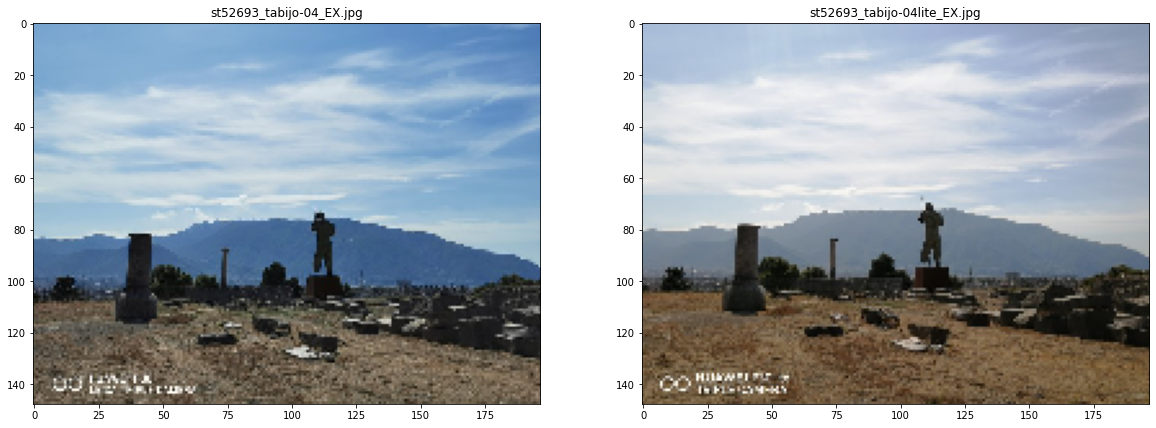

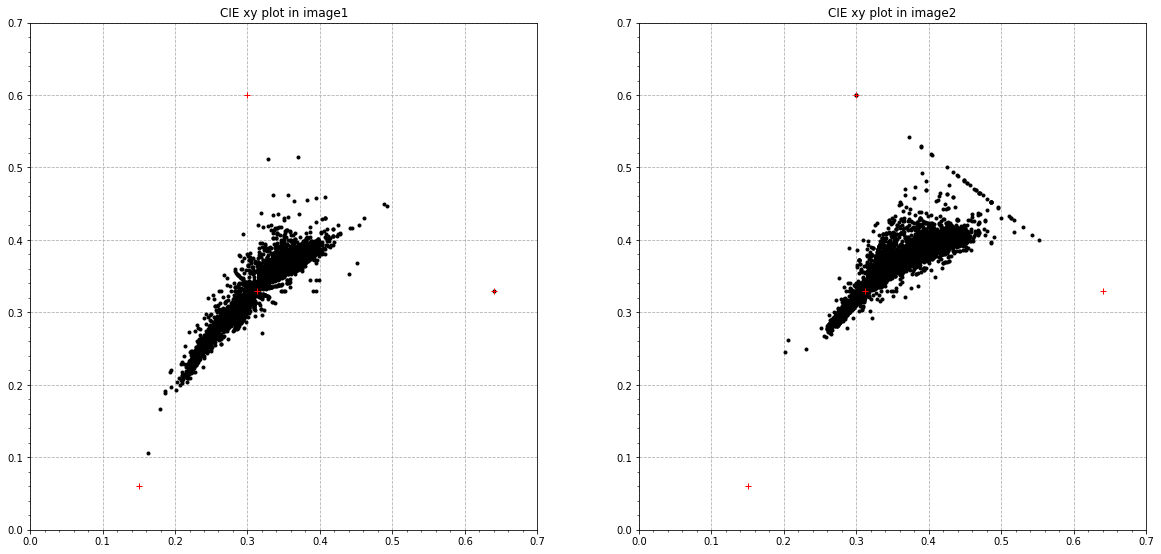

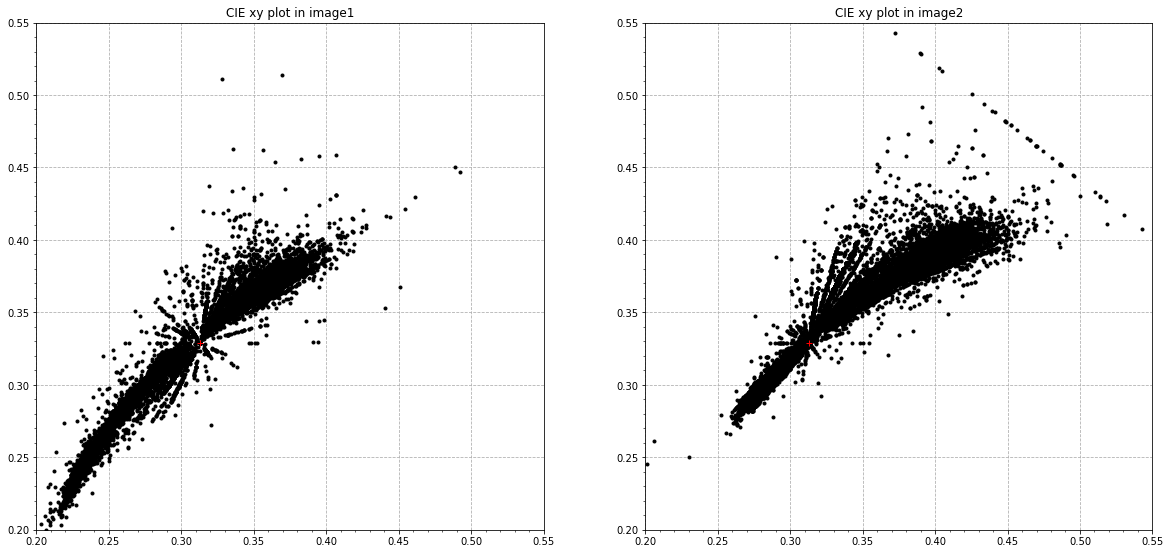

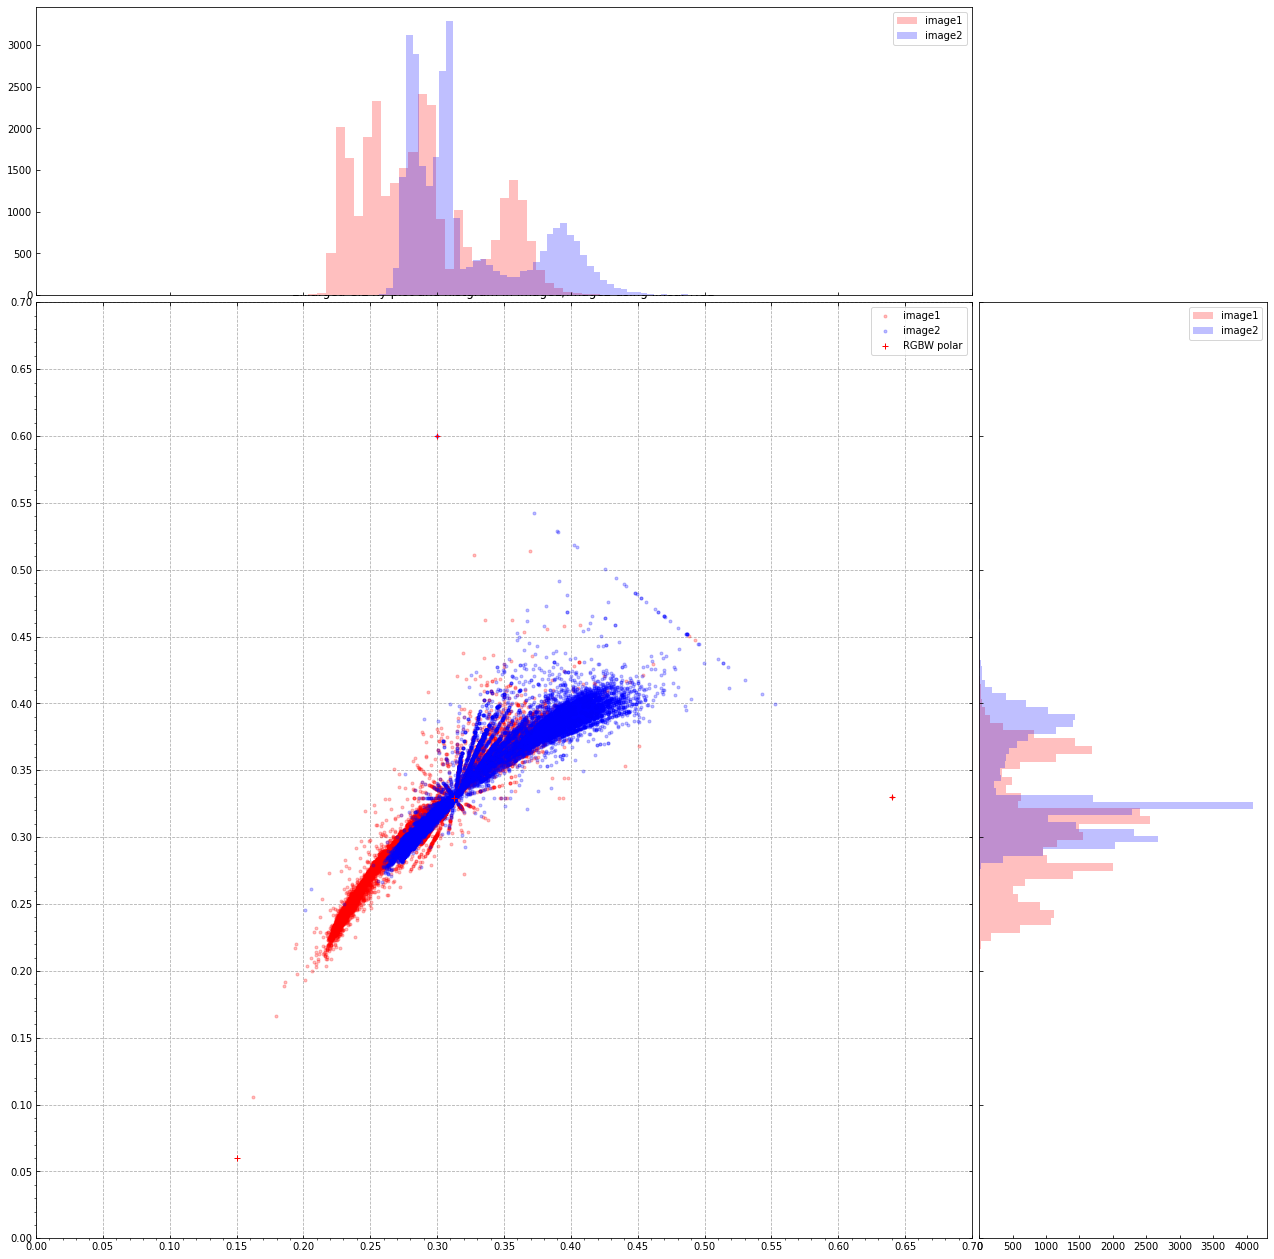

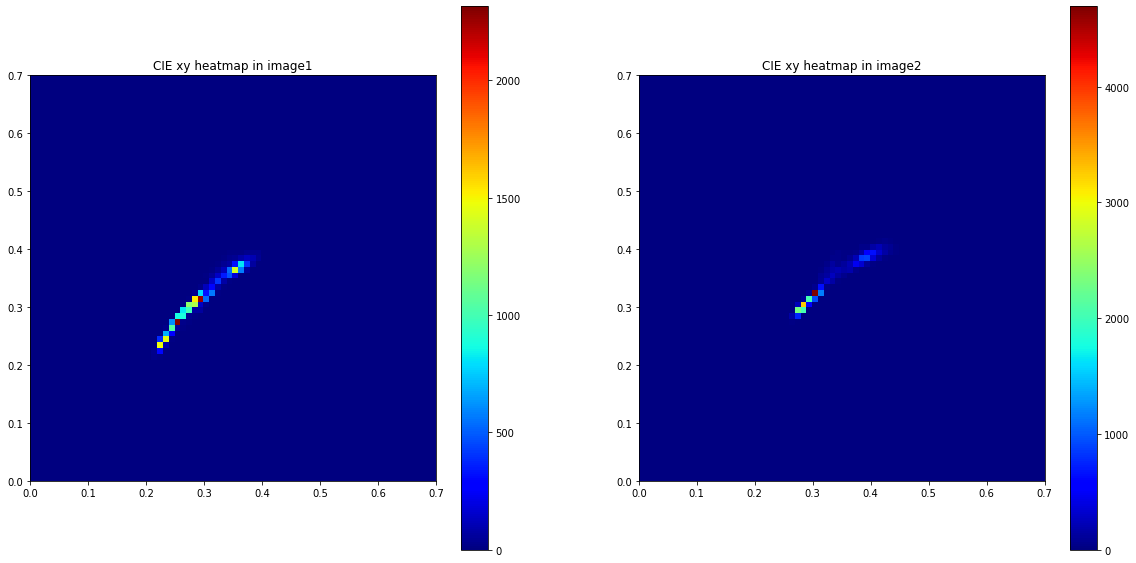

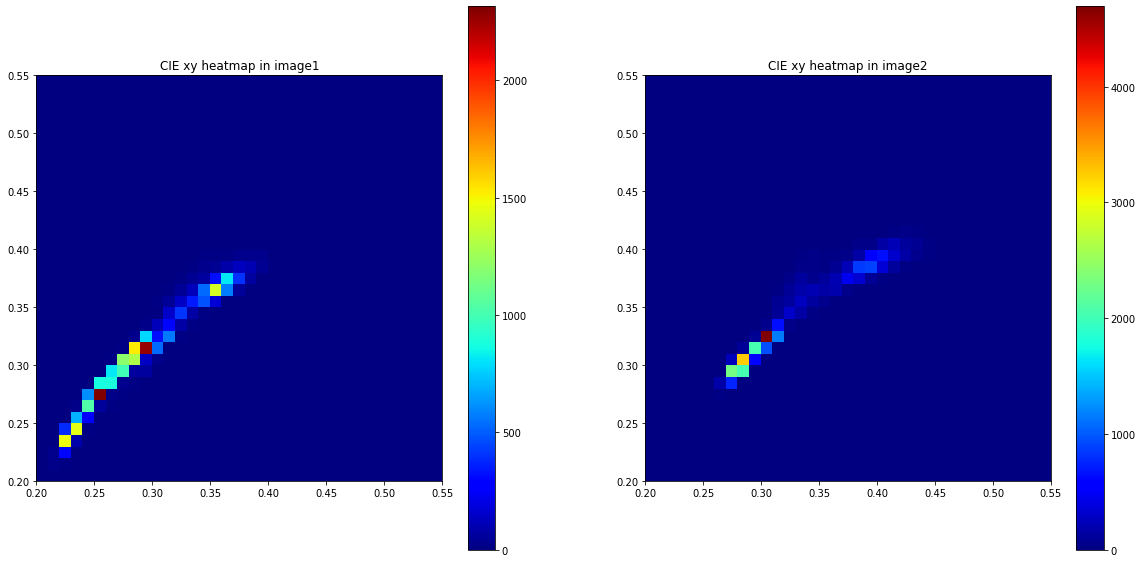

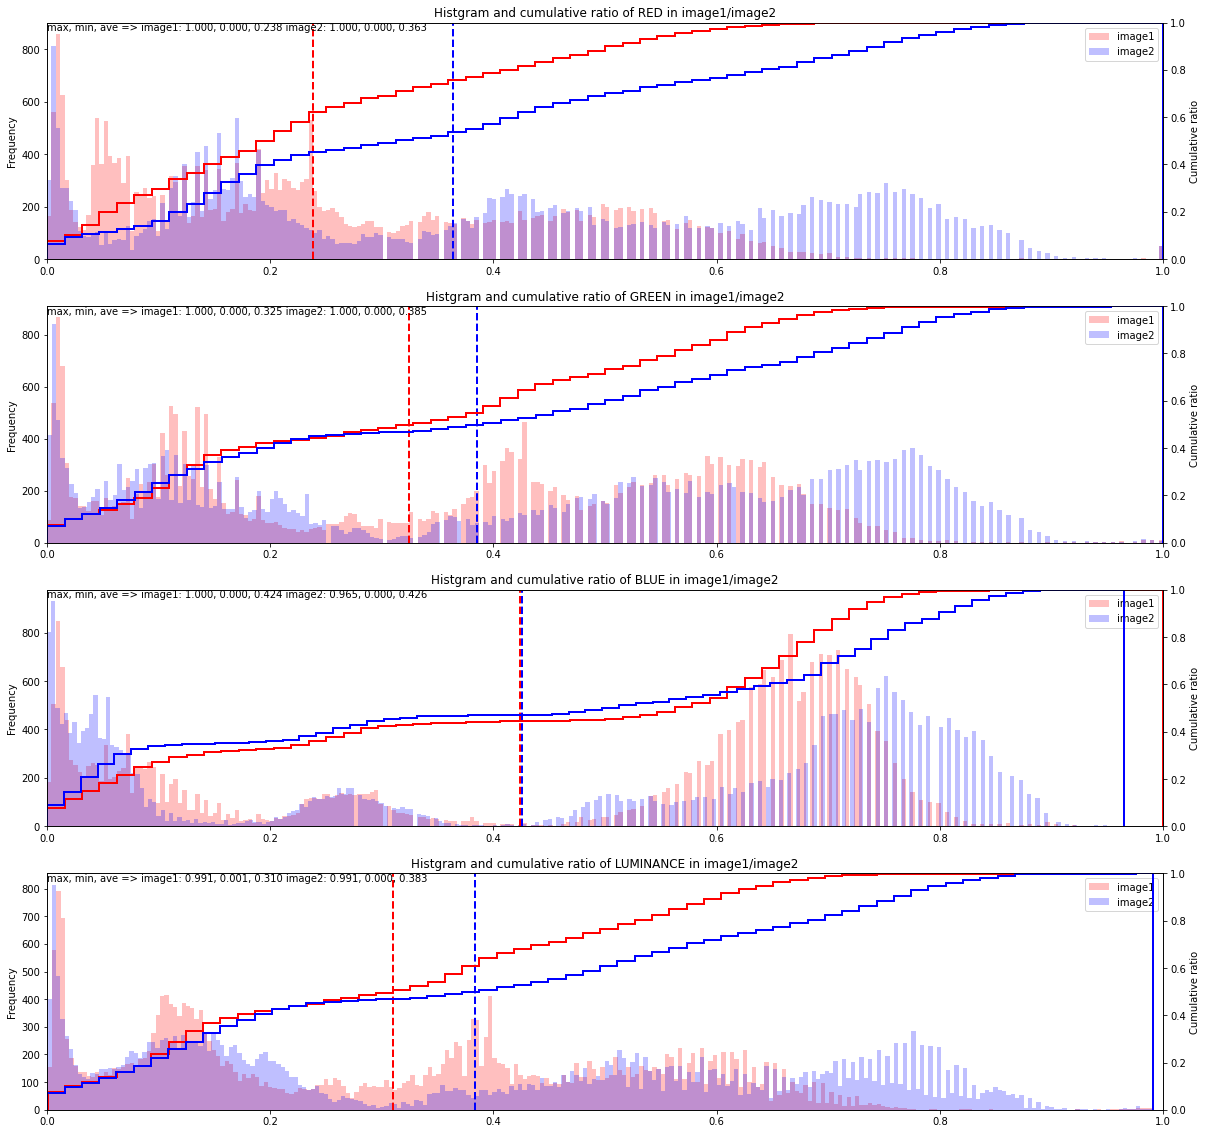

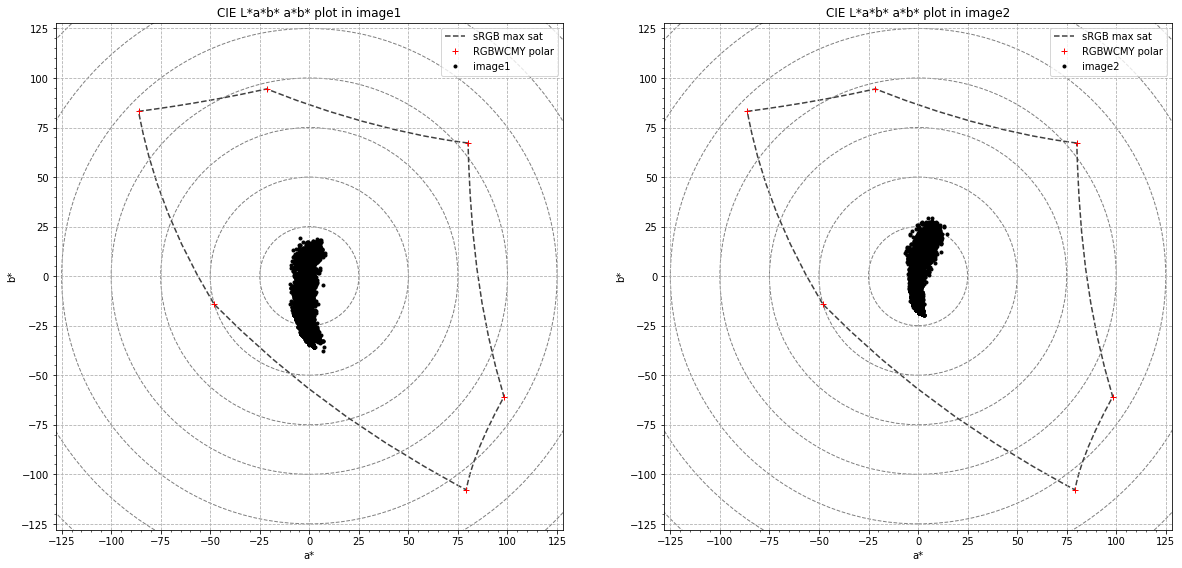

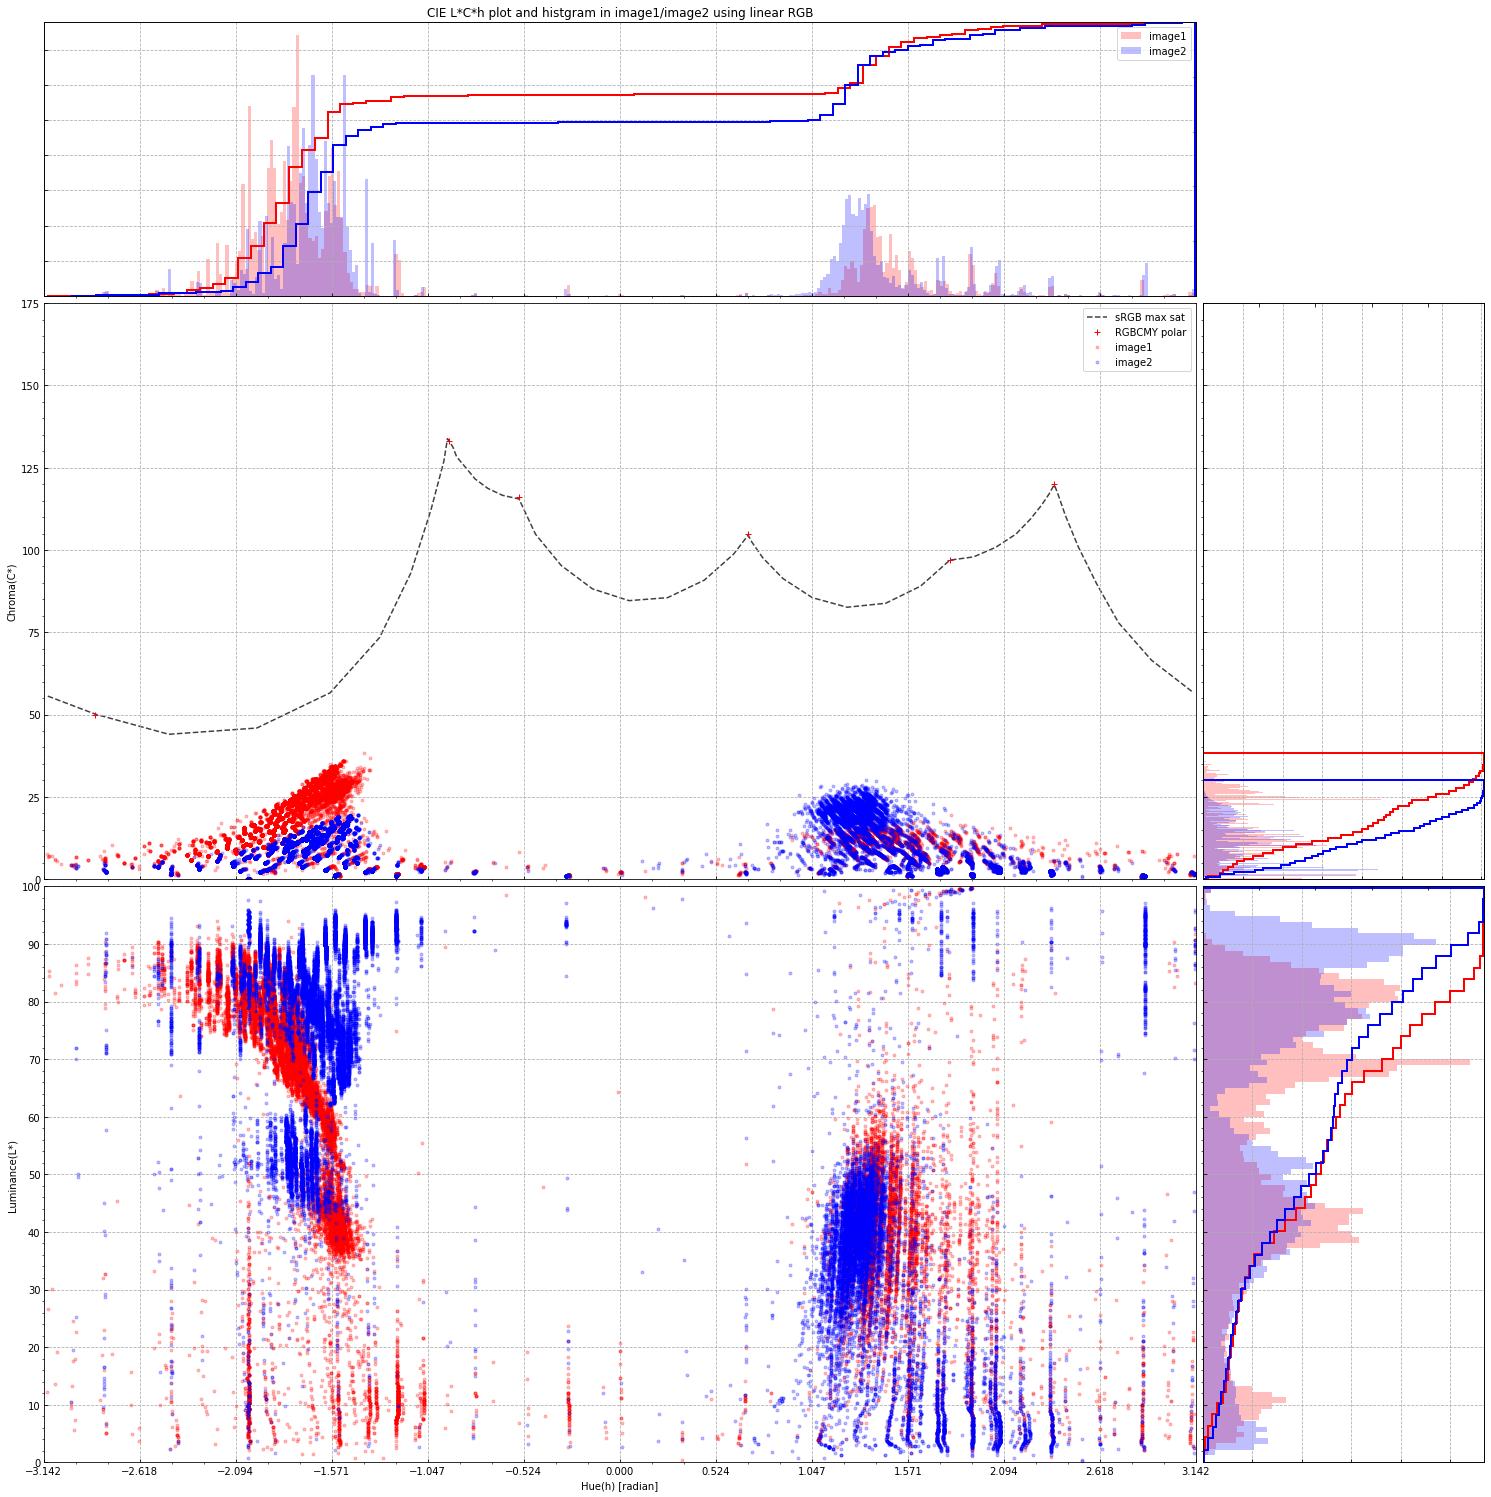

In [1]:
#@title
# -*- coding: utf-8 -*-

# import libraries
from enum import Enum
from google.colab import files
import io
from matplotlib import cm as cm
from matplotlib import patches as patches
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import numpy as np
from PIL import Image
import sys

## WhitePoint定数
class WhitePoint(Enum):
  D65 = 1
  D50 = 2

### 複数個所で使われる定数 
DEFAULT_DTYPE = np.float32              # numpyで用いる型

## 全プロット共通の定義 ... スマホ向けにしようとした場合、他の部分も変更が必要
PLOT_AREA_LANDSCAPE = (20, 10)    # プロット領域横長
PLOT_AREA_SQUARE = (20, 20)       # プロット領域正方
MIX_TRANSPARENT_RATE = 0.25       # 重ね合わせのあるプロットなどでの透過率
HIST_CUMULATIVE_Y_LIM = 0, 1.0    # 累積線の下限、上限。Y軸は割合なので0～1.0
CUMULATIVE_TRANSPARENT_RATE = 1.0 # 累積線の透過率。ヒストグラムが透過で区別するため非透過
CUMULATIVE_LINE_WIDTH = 2         # 累積線の線幅。1でヒストグラム内での視認が悪く変更

## CIE xyに特化したパラメータ
CIEXY_RGBW_POLARS = np.array(
    [[0.64, 0.33], [0.30, 0.60], [0.15, 0.06], [0.3127, 0.3290]]
) # CIX xyプロット上で固定でプロットする座標(sRGB色空間のR,G,B,Wの極値)

## CIE xyプロットの表現範囲及びプロット周りの設定
CIEXY_PLOT_X_LIM = (0, 0.7)             # sRGB全体をカバーするX軸の下限、上限
CIEXY_PLOT_Y_LIM = (0, 0.7)             # sRGB全体をカバーするY軸の下限、上限
CIEXY_CROPPED_PLOT_X_LIM = (0.2, 0.55)  # 主な光源色をカバーするX軸の下限、上限
CIEXY_CROPPED_PLOT_Y_LIM = (0.2, 0.55)  # 主な光源色をカバーするY軸の下限、上限
CIEXY_MAJOR_LOCATOR = 0.1               # ガイド付きのメモリ間隔
CIEXY_CROPPED_MAJOR_LOCATOR = CIEXY_MAJOR_LOCATOR / 2 # ガイド付きのメモリ間隔
CIEXY_MINOR_LOCATOR_DIVIDER = 5         # ガイド付きのメモリ間隔の小メモリの分割数
CIEXY_HIST_BINS = 70                    # ヒストグラムの分割数、現状プロット表現範囲0～0.7に合わせて0.01の粒度で分割
CIEXY_GRID_LINESTYLE = "--"             # CIE xyプロットのグリッド線の形状
CIEXY_PLOT_MARKER = '.'                 # CIE xyプロットのプロットマーカー形状
CIEXY_PLOT_LINESTYLE = ''               # CIE xyプロットのプロット間の線の形状
CIEXY_PLOT_POLAR_COLOR = 'red'          # sRGBの極値のプロット色
CIEXY_PLOT_POLAR_MARKER = '+'           # sRGBの極値のプロットマーカー形状
CIEXY_PLOT_POLAR_LINESTYLE = ''         # sRGBの極値間の線の形状（表示しない）

## CIE Labプロットの表現範囲及びプロット周りの設定
CIELAB_DEFAULT_WHITEPOINT = WhitePoint.D65
CIEAB_PLOT_A_LIM = (-128, 128)
CIEAB_PLOT_B_LIM = (-128, 128)
CIEAB_MAJOR_LOCATOR = 25
CIEAB_PLOT_MARKER = '.'                 # CIE abプロットのプロットマーカー形状
CIEAB_PLOT_LINESTYLE = ''               # CIE abプロットのプロット間の線の形状
CIELCH_PLOT_MARKER = '.'                # CIE LChプロットのプロットマーカー形状
CIELCH_PLOT_LINESTYLE = ''              # CIE LChプロットのプロット間の線の形状
CIEH_HIST_BINS = 360                    # Hヒストグラムの分割数(1度単位)
CIEL_HIST_BINS = 100                    # Lヒストグラムの分割数
CIEC_HIST_BINS = 175                    # Cヒストグラムの分割数(sRGBのBの最大彩度)
CIELABLCH_PLOT_SRGB_POLAR_COLOR = 'red' # sRGBの極値のプロット色
CIELABLCH_PLOT_SRGB_POLAR_MARKER = '+'  # sRGBの極値のプロットマーカー形状
CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE = ''# sRGBの極値間の線の形状（表示しない）
CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR = '#404040'  # sRGBの最大彩度のプロット色
CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE = '--'  # sRGBの最大彩度のプロット色

# 輝度ヒストグラムのパラメータ
RGB2Y_CONVERT_MATRIX = np.array([0.299, 0.587, 0.114]) # ITU-R BT.601 に従った輝度Yの変換行列

## プロットで画像毎にループするときに用いる定数（現状2つの画像まで）
IMAGE1_COLOR = 'red'
IMAGE2_COLOR = 'blue'
COLORS = [IMAGE1_COLOR, IMAGE2_COLOR]
LOOP_MAX = len(COLORS)


def main():

  ## Google Colabに特化した画像読み込み
  # 一括で2つ画像指定と分割で1つずつ画像指定に対応
  # 3つ以上や0個などは強制終了
  uploaded_images = files.upload()

  if(len(uploaded_images) == 1):
    uploaded_images2 = files.upload()
    if(len(uploaded_images2) != 1):
      print("This program require 2 image files. So, please retry again.")
      sys.exit(1)
    else:
      uploaded_images.update(uploaded_images2)
  elif(len(uploaded_images) != 2):
    print("This program requires 2 image files. So, please retry again.")
    print(uploaded_images.keys())
    sys.exit(1)

  ims = list()
  im_fnames = list()
  for k, v in uploaded_images.items():
    img_bin = io.BytesIO(v)
    ims.append(Image.open(img_bin))
    im_fnames.append(k)

  # 画像データの前処理
  ciexyzs = list()
  normalizedRGBs = list()
  reducedImages = list()
  cielabs = list()
  cielchs = list()
  for im in ims:
    print(im.size, im.mode)
    im_list = np.asarray(im)

    # 画像の間引き：長編を256未満にする間引き
    MAX_IMG_WIDTH = 256
    (img_x, img_y, img_dim) = im_list.shape
    if img_x  > img_y:
      skip = int(img_x / MAX_IMG_WIDTH) + 1
      im_list2 = im_list[::skip,::skip,::]
      reducedImages.append(np.transpose(im_list2, axes=(1,0,2)))
    else:
      skip = int(img_y / MAX_IMG_WIDTH) + 1
      im_list2 = im_list[::skip,::skip,::]
      reducedImages.append(im_list2)

    # RGB to CIE xyz/CIE XYZ/CIE L*a*b*/CIE L*C*h
    normalizedRGB = normalizeLinearRgb(im_list2)
    normalizedRGBs.append(normalizedRGB)
    cieXYZ = convertToCieXYZ(normalizedRGB)
    ciexyzs.append(convertToCiexyz(cieXYZ))
    cielabs.append(convertToCielab(cieXYZ))
    cielchs.append(convertToCielch(cielabs[-1]))

  # プロット用にCIE xyとRGBLのデータ抽出
  image_x = list()
  image_y = list()
  image_a = list()
  image_b = list()
  image_l = list()
  image_c = list()
  image_h = list()

  for i in range(LOOP_MAX):
    image_x.append(ciexyzs[i][0:, 0])
    image_y.append(ciexyzs[i][0:, 1])
    image_a.append(cielabs[i][0:, 1])
    image_b.append(cielabs[i][0:, 2])
    image_l.append(cielchs[i][0:, 0])
    image_c.append(cielchs[i][0:, 1])
    image_h.append(cielchs[i][0:, 2])
  
  temp = normalizedRGBs[0].reshape(-1, 3)
  image1_r = temp[0:, 0]
  image1_g = temp[0:, 1]
  image1_b = temp[0:, 2]
  image1_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)
  temp = normalizedRGBs[1].reshape(-1, 3)
  image2_r = temp[0:, 0]
  image2_g = temp[0:, 1]
  image2_b = temp[0:, 2]
  image2_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)

  # 画像表示
  plotImage(reducedImages, im_fnames)

  # プロット1 CIE xyのプロット、画像毎にプロット
  plotCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,
      CIEXY_MAJOR_LOCATOR)

  # プロット3 CIE xyのプロット、画像2つのセパレートの局所ズーム版
  plotCiexy(
      image_x, image_y, CIEXY_CROPPED_PLOT_X_LIM, CIEXY_CROPPED_PLOT_X_LIM,
      CIEXY_CROPPED_MAJOR_LOCATOR)

  # プロット4 CIE xyのプロット、画像2つの合同プロット拡大版＋xとy毎のヒストグラム
  plotSuperimposedCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,
      CIEXY_CROPPED_MAJOR_LOCATOR)

  # プロット5 CIE xyのヒートマップ、通常版と局所ズーム版
  plotHeatmapCiexy(
      image_x, image_y, CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,)
  plotHeatmapCiexy(
      image_x, image_y, CIEXY_CROPPED_PLOT_X_LIM, CIEXY_CROPPED_PLOT_Y_LIM)

  # プロット6 リニアRGGと輝度のヒストグラム
  histRgbl(
      image1_r, image1_g, image1_b, image1_l,
      image2_r, image2_g, image2_b, image2_l
  )

  # プロット7 CIE L*a*b* の a/bプロット、画像毎にプロット
  plotCieab(
      image_a, image_b, CIEAB_PLOT_A_LIM, CIEAB_PLOT_B_LIM,
      CIEAB_MAJOR_LOCATOR
  )

  # プロット8 CIE L*C*h の h/C* h/L*プロット、L*/C*/h毎のヒストグラム
  plotSuperimposedCielch(image_l, image_c, image_h)

  plt.show()


def normalizeLinearRgb(originPixel):
  """Normalize RGB data and revert gamma correction.
  Args:
      originPixel (numpy.ndarray): Image data which has 3 dimensional data(height/width/RGB). The RGB data takes value from 0 to 255 and corrects gamma curb 2.2.
  Returns:
      numpy.ndarray: Normalized and reverted gamma correction image data(height/width/RGB).
  """
  # JPEGを前提として、RGBの各々の解像度8bit(255)と定義
  RGB_RESOLUTION = 255

  # 0～1の間で正規化
  tempPixel = originPixel / RGB_RESOLUTION

  # ガンマ補正を元に戻し、リニア化
  #   正規化値  <= 0.04045 : 正規化値 / 12.92
  #   正規化値  >  0.04045 : ((正規化値 + 0.055) / 1.055) に 2.4階乗
  LINEAR_THR = 0.04045
  ret_arr = np.piecewise(
      tempPixel,
      [
       tempPixel <= LINEAR_THR,
       tempPixel > LINEAR_THR
       ],
      [
       lambda tempPixel: tempPixel/12.92,
       lambda tempPixel: ((tempPixel+0.055)/1.055)**2.4
       ])

  # 正規化RGBが、0.0, 0.0, 0.0 の時、
  # 後の処理で0除算によるランタイム警告になるので、0に近い最小値に置換
  ret_arr[np.where(np.sum(ret_arr, axis=2) == 0)] = [
    np.finfo(DEFAULT_DTYPE).tiny,
    np.finfo(DEFAULT_DTYPE).tiny,
    np.finfo(DEFAULT_DTYPE).tiny]

  return ret_arr.astype(DEFAULT_DTYPE)


def convertToCieXYZ(normalizedRgb):
  """Convert from normalized RGB image to CIE XYZ data using matrix for sRGB.
  Args:
      normalizedRgb (numpy.ndarray): Normalized and reverted gamma correction image data(height/width/RGB).
  Returns:
      numpy.ndarray: CIE XYZ data has 2 dimensional data(serialized array/XYZ).
  """
  # RGB of sRGB color space to CIE XYZ convert matrix
  MATRIX = np.array(
      [[0.412424, 0.357579, 0.180464],
       [0.212656, 0.715158, 0.072186],
       [0.019332, 0.119193, 0.950444]], dtype=DEFAULT_DTYPE)

  # 1次元行列のまま2次元行列を掛けるため
  # 掛け算の順序逆転と2次元配列を転置してからRGBからXYZを算出
  ret_arr = np.dot(normalizedRgb, MATRIX.T)

  # 前の実装を維持するため、2次元配列を1次元配列
  return ret_arr.reshape(-1, 3)


def convertToCiexyz(cieXYZ):
  """Convert from CIE XYZ data to CIE xyz data.
  Args:
      cieXYZ (numpy.ndarray): CIE XYZ data.
  Returns:
      numpy.ndarray: CIE xyz data has 2 dimensional data(serialized array/xyz).
  """
  # 画素毎にXYZからxyzを算出
  #   x = X / (X + Y + Z)
  #   y = Y / (X + Y + Z)
  #   z = Z / (X + Y + Z)
  # (X+Y+Z)の結果を並べてまとめて除算
  return cieXYZ / np.tile(np.sum(cieXYZ, axis=1), (3,1)).T


def convertToCielab(cieXYZ):
  """Convert from CIE XYZ data to CIE L*a*b* data.
  Args:
      cieXYZ (numpy.ndarray): CIE XYZ data.
  Returns:
      numpy.ndarray: CIE L*a*b* data has 2 dimensional data(serialized arrray/L*a*b*).
  """
  # 画素ごとにXYZからL*a*b*を算出
  #   L* = 116 * f(Y/Yn) -16
  #   a* = 500 * (f(X/Xn) - f(Y/Yn))
  #   b* = 200 * (f(Y/Yn) - f(Z/Zn))
  #
  #   f(t) = t ^ (1/3) ... t > (6/29)^3
  #   f(t) = (1/3) * (29/6)^2 * t + (4/29) ... t <= (6/29)^3

  # 現時点で4段階の計算に分ける予定
  #   1. CIE XYZ => X/Xn, Y/Yn, Z/Zn
  #   2. X/Xn, Y/Yn, Z/Zn => f(X/Xn), f(Y/Yn), f(Z/Zn)
  #   3. f(X/Xn), f(Y/Yn), f(Z/Zn) => L* + 16, a*, b*
  #   4. L* + 16, a*, b* => L*, a*, b*

  # 基準点の白点と変換式の行列
  REFERENCEPOINT_D50 = np.array([
    [0.964212,  1.0,  0.825188],], dtype=DEFAULT_DTYPE)
  REFERENCEPOINT_D65 = np.array([
    [0.950489,  1.0,  1.088840],], dtype=DEFAULT_DTYPE)
  CONVERT_MATRIX = np.array([
    [0.0, 116.0, 0.0],
    [500.0, -500.0, 0.0],
    [0.0, 200.0, -200.0]], dtype=DEFAULT_DTYPE)
  L_OFFSET = np.array([
    [-16.0, 0.0, 0.0],], dtype=DEFAULT_DTYPE)
  
  # 基準のWhitePointの補正
  if CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D65:
    correctedWPXYZ = cieXYZ / REFERENCEPOINT_D65
  elif CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D50:
    correctedWPXYZ = cieXYZ / REFERENCEPOINT_D50
  
  THR = 0.008856451679035631 # (6/29)^3
  preConverted =  np.piecewise(
    correctedWPXYZ,
    [
      correctedWPXYZ <= THR,
      correctedWPXYZ > THR
    ],
    [
      lambda correctedWPXYZ:
        7.787037037037035 * correctedWPXYZ + 0.13793103448275862,
      lambda correctedWPXYZ:
        correctedWPXYZ ** 0.3333333333333333
    ])
  return np.dot(preConverted, CONVERT_MATRIX.T) + L_OFFSET


def convertToCielch(cieLab):
  """Convert from CIE L*a*b* data to CIE L*C*h data.
  Args:
      cieLab (numpy.ndarray): CIE L*a*b* data.
  Returns:
      numpy.ndarray: CIE L*C*h data has 2 dimensional data(serialized arrray/L*C*h).
  """
  c = np.sqrt(
    np.power(cieLab[0:,1], 2) + np.power(cieLab[0:,2], 2),
    dtype=DEFAULT_DTYPE)
  h = np.arctan2(cieLab[0:,2], cieLab[0:,1], dtype=DEFAULT_DTYPE)
  return np.c_[cieLab[0:,0], c, h]


# plot Image
def plotImage(images, fnames):
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image = root_fig.add_subplot(
        1, LOOP_MAX, (i+1), title="%s"%fnames[i])
    image.imshow(images[i])


# plot CIE xy of 2 images
def plotCiexy( image_x, image_y, x_lim, y_lim, major_locator):
  # プロット形状を明確にするため、黒の非透過を採用
  plot_color =  'black'
  plot_transparent_rate = 1.0

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_plot = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE xy plot in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    image_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
    image_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.plot(
        image_x[i], image_y[i],
        color=plot_color, marker=CIEXY_PLOT_MARKER,
        linestyle=CIEXY_PLOT_LINESTYLE,
        alpha=plot_transparent_rate, label="image%d"%(i+1))
    image_plot.plot(
        CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
        color=CIEXY_PLOT_POLAR_COLOR, marker=CIEXY_PLOT_POLAR_MARKER,
        linestyle=CIEXY_PLOT_POLAR_LINESTYLE, label="RGBW polar")


# plot superimposed CIE xy of 2 images
def plotSuperimposedCiexy(image_x, image_y, x_lim, y_lim, major_locator):
  # 描画領域の定義 ... 中身はmatplotlib公式のサンプルそのまま
  LEFT, WIDTH = 0.1, 0.65
  BOTTOM, HEIGHT = 0.1, 0.65
  SPACING = 0.005
  RECT_PLOT = [LEFT, BOTTOM, WIDTH, HEIGHT]
  RECT_HISTX = [LEFT, BOTTOM + HEIGHT + SPACING, WIDTH, 0.2]
  RECT_HISTY = [LEFT + WIDTH + SPACING, BOTTOM, 0.2, HEIGHT]

  # 描画領域の初期化
  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  images_plot = root_fig.add_axes(RECT_PLOT)
  images_plot.tick_params(direction='in', top=True, right=True)
  hist_x = root_fig.add_axes(RECT_HISTX)
  hist_x.tick_params(direction='in', labelbottom=False)
  hist_y = root_fig.add_axes(RECT_HISTY)
  hist_y.tick_params(direction='in', labelleft=False)

  # プロットやヒストグラムの共通設定
  images_plot.set_title(
      'Enlarged CIE xy plot and histgram in image1/image2 using linear RGB')
  images_plot.set_xlim(x_lim)
  images_plot.set_ylim(y_lim)
  images_plot.set_aspect('equal')
  images_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
  images_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
  images_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
  images_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  images_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  hist_x.set_xlim(images_plot.get_xlim())
  hist_y.set_ylim(images_plot.get_ylim())

  # プロットとヒストグラムの描画
  for i in range(LOOP_MAX):
    images_plot.plot(
        image_x[i], image_y[i],
        color=COLORS[i], marker=CIEXY_PLOT_MARKER,
        linestyle=CIEXY_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    hist_x.hist(
        image_x[i], bins=CIEXY_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    hist_y.hist(
        image_y[i], bins=CIEXY_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1),
        orientation='horizontal')

  # RGBWの極値のプロット
  images_plot.plot(
      CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
      color=CIEXY_PLOT_POLAR_COLOR, marker=CIEXY_PLOT_POLAR_MARKER,
      linestyle=CIEXY_PLOT_POLAR_LINESTYLE, label="RGBW polar")

  images_plot.legend()
  hist_x.legend()
  hist_y.legend()


# heatmap CIE xy of 2 images
def plotHeatmapCiexy( image_x, image_y, x_lim, y_lim):
  # ヒートマップの分解能を定義
  RESOLUTION = 0.01 # resolution of heatmap
  (xmin, xmax) = x_lim
  (ymin, ymax) = y_lim
  BINS = [int((xmax-xmin)/RESOLUTION), int((ymax-ymin)/RESOLUTION)]

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_hm = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE xy heatmap in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    H = image_hm.hist2d(
        image_x[i], image_y[i],
        bins=BINS, range=[list(x_lim), list(y_lim)], cmap=cm.jet)
    plt.colorbar(H[3], ax=image_hm)


def histRgbl(
    image1_r, image1_g, image1_b, image1_l,
    image2_r, image2_g, image2_b, image2_l):
  
  # ヒストグラムの共通のパラメータ
  RGBY_HIST_X_LIM = 0, 1.0  # 表現範囲でX軸の下限、上限。現状0.0～1.0に正規化
  RGBY_HIST_BINS = 256      # 分割数。現状あまり意味はないが、正規化前の256段階
  AVE_LINESTYLE = '--'      # 平均値の線状。ヒストグラムが塗りつぶしで混同するので破線
  AVE_LINE_WIDTH = 2        # 平均値の線幅。1でヒストグラム内での視認が悪く変更

  # 累積表示の共通パラメータ
  RGBY_CUMULATIVE_BINS = int(RGBY_HIST_BINS / 4) # 分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目

  # ループ処理のためのデータの連結
  image1s = [image1_r, image1_g, image1_b, image1_l]
  image2s = [image2_r, image2_g, image2_b, image2_l]
  TITLES = [
            'Histgram and cumulative ratio of RED in image1/image2',
            'Histgram and cumulative ratio of GREEN in image1/image2',
            'Histgram and cumulative ratio of BLUE in image1/image2',
            'Histgram and cumulative ratio of LUMINANCE in image1/image2'       
  ]
  hist_num = len(TITLES)

  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  for i in range(hist_num):
    # ヒストグラムの描画
    hist1 = root_fig.add_subplot(hist_num, 1, i+1, xlim=RGBY_HIST_X_LIM)
    hist1.set_title(TITLES[i])
    hist1.hist(
        image1s[i], bins=RGBY_HIST_BINS, color=IMAGE1_COLOR,
        alpha=MIX_TRANSPARENT_RATE, label="image1")
    hist1.hist(
        image2s[i], bins=RGBY_HIST_BINS, color=IMAGE2_COLOR,
        alpha=MIX_TRANSPARENT_RATE, label="image2")
    hist1.axvline(
        image1s[i].mean(), color=IMAGE1_COLOR,
        linestyle=AVE_LINESTYLE, linewidth=AVE_LINE_WIDTH)
    hist1.axvline(
        image2s[i].mean(), color=IMAGE2_COLOR,
        linestyle=AVE_LINESTYLE, linewidth=AVE_LINE_WIDTH)
    hist1.set_ylabel('Frequency')
    hist1.legend()

    # 累計の割合をヒストグラムと同梱(x軸共有、y軸別)で描画
    hist2 = hist1.twinx()
    hist2.set_ylim(HIST_CUMULATIVE_Y_LIM)
    hist2.hist(
        image1s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE1_COLOR, alpha=CUMULATIVE_TRANSPARENT_RATE,
        linewidth=CUMULATIVE_LINE_WIDTH)
    hist2.hist(
        image2s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE2_COLOR, alpha=CUMULATIVE_TRANSPARENT_RATE,
        linewidth=CUMULATIVE_LINE_WIDTH)
    hist2.set_ylabel('Cumulative ratio')
    note = "max, min, ave => image1: {:.3f}, {:.3f}, {:.3f} image2: {:.3f}, {:.3f}, {:.3f}".format(
        image1s[i].max(), image1s[i].min(), image1s[i].mean(),
        image2s[i].max(), image2s[i].min(), image2s[i].mean())
    hist2.text(
        0.0, 1.0, note, fontsize=10,
        verticalalignment='top', horizontalalignment='left',
        transform=hist2.transAxes)


# plot a/b of CIE L*a*b* of 2 images
def plotCieab( image_a, image_b, x_lim, y_lim, major_locator):
  # プロット形状を明確にするため、黒の非透過を採用
  plot_color =  'black'
  plot_transparent_rate = 1.0

  # sRGBのRed/Green/Blue/White/Cyan/Magenta/Yellow極値と最大彩度の定数
  if CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D65:
    SRGB_RGBWCMY_POLARS = np.array(
      # [[100.0, 100.0], [100.0, -100.0], [-100.0, -100.0], [-100.0, 100.0]]
      [[80.1, 67.2], [-86.2, 83.2], [79.2, -107.9], [-0.004, -0.008],
       [-48.1, -14.1], [98.2, -60.8], [-21.6, 94.5]]
    )
    AB_SRGB_A = [
      80.09, 76.91, 69.36, 57.58, 42.82, 26.53, 9.86, -6.46, -21.56,
      -21.56, -34.11, -46.50, -57.89, -67.79, -75.76, -81.47, -84.83, -86.19,
      -86.19, -85.53, -83.87, -80.97, -76.75, -71.22, -64.45, -56.59, -48.09,
      -48.09, -34.12, -18.18, -0.52, 18.78, 38.99, 58.06, 72.41, 79.19,
      79.19, 79.41, 80.01, 81.21, 83.17, 85.95, 89.49, 93.68, 98.23,
      98.23, 94.13, 90.37, 87.15, 84.53, 82.54, 81.18, 80.40, 80.09
    ]
    AB_SRGB_B = [
      67.20, 67.60, 68.70, 70.81, 74.02, 78.22, 83.19, 88.74, 94.48,
      94.48, 91.81, 89.42, 87.42, 85.82, 84.63, 83.82, 83.36, 83.18,
      83.18, 79.73, 71.91, 60.38, 46.57, 31.61, 16.18, 0.70, -14.14,
      -14.14, -27.74, -42.10, -56.60, -70.92, -84.44, -96.05, -104.18, -107.86,
      -107.86, -106.72, -103.93, -99.38, -93.30, -86.06, -78.01, -69.4, -60.83,
      -60.83, -46.17, -30.25, -13.50, 4.07, 22.33, 40.69, 57.18, 67.20
   ]
  elif CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D50:
    SRGB_RGBWCMY_POLARS = np.array(
      [[78.3, 62.2], [-88.0, 73.9], [77.8, -126.4], [-2.4, -19.4],
      [-50.1, -33.4], [96.2, -79.5], [-23.8, 84.7]]
    )
    AB_SRGB_A = [
      78.28, 75.09, 67.53, 55.72, 40.91, 24.56, 7.81, -8.59, -23.78,
      -23.78, -36.23, -48.52, -59.82, -69.64, -77.55, -83.22, -86.56, -87.91,
      -87.91, -87.25, -85.60, -82.72, -78.53, -73.03, -66.31, -58.50, -50.06,
      -50.06, -35.97, -19.92, -2.16, 17.24, 37.52, 56.65, 71.03, 77.82,
      77.82, 78.02, 78.59, 79.72, 81.60, 84.28, 87.71, 91.77, 96.20,
      96.20, 92.15, 88.44, 85.26, 82.67, 80.71, 79.36, 78.59, 78.28
    ]
    AB_SRGB_B = [
      62.15, 62.40, 63.16, 64.75, 67.32, 70.80, 75.01, 79.77, 84.74,
      84.74, 82.19, 79.90, 77.99, 76.45, 75.31, 74.53, 74.09, 73.92,
      73.92, 70.12, 61.52, 48.84, 33.64, 17.15, 0.13, -16.97, -33.39,
      -33.39, -46.81, -61.00, -75.38, -89.60, -103.04, -114.60, -122.70, -126.37,
      -126.37, -125.23, -122.45, -117.90, -111.83, -104.61, -96.58, -88.04, -79.47,
      -79.47, -63.10, -45.39, -26.81, -7.37, 12.80, 33.01, 51.14, 62.15
   ]

  # プロット
  root_fig = plt.figure(figsize=PLOT_AREA_LANDSCAPE)
  for i in range(LOOP_MAX):
    image_plot = root_fig.add_subplot(
        1, LOOP_MAX, i+1, title="CIE L*a*b* a*b* plot in image%d"%(i+1),
        xlim=x_lim, ylim=y_lim, aspect='equal')
    image_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
    image_plot.grid(linestyle=CIEXY_GRID_LINESTYLE, zorder=-10)
    image_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    image_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
    for j in range(9):
      grid_circle = patches.Circle(
        xy=(0, 0), radius=(j*25.0), fill=False,
        edgecolor='gray', linestyle="--", zorder=-10)
      image_plot.add_patch(grid_circle)
    image_plot.plot(
        AB_SRGB_A, AB_SRGB_B,
        color=CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR,
        linestyle=CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE, alpha=1.0, zorder=-5.0,
        label="sRGB max sat"
    )
    image_plot.plot(
        SRGB_RGBWCMY_POLARS[0:,0], SRGB_RGBWCMY_POLARS[0:,1],
        color=CIELABLCH_PLOT_SRGB_POLAR_COLOR,
        marker=CIELABLCH_PLOT_SRGB_POLAR_MARKER,
        linestyle=CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE, label="RGBWCMY polar")
    image_plot.plot(
        image_a[i], image_b[i],
        color=plot_color, marker=CIEAB_PLOT_MARKER,
        linestyle=CIEAB_PLOT_LINESTYLE,
        alpha=plot_transparent_rate, label="image%d"%(i+1))
    image_plot.set_xlabel("a*")
    image_plot.set_ylabel("b*")
    image_plot.legend()


# plot superimposed CIE xy of 2 images
def plotSuperimposedCielch(image_l, image_c, image_h):
  # 描画領域の定義 ... 中身はmatplotlib公式のサンプルそのまま
  LEFT, WIDTH = 0.0, 0.8
  BOTTOM, HEIGHT = 0.0, 0.4
  SPACING = 0.005
  HL_PLOT = [LEFT, BOTTOM, WIDTH, HEIGHT]
  HC_PLOT = [LEFT, BOTTOM+HEIGHT+SPACING, WIDTH, HEIGHT]
  H_HIST  = [LEFT, BOTTOM+2*(HEIGHT+SPACING), WIDTH, 1-2*(HEIGHT+SPACING)]
  L_HIST  = [LEFT+WIDTH+SPACING, BOTTOM, 1-(WIDTH+SPACING), HEIGHT]
  C_HIST  = [LEFT+WIDTH+SPACING, BOTTOM+HEIGHT+SPACING, 1-(WIDTH+SPACING), HEIGHT]

  # 共通のパラメータ
  CIEH_CUMULATIVE_BINS = int(CIEH_HIST_BINS / 4) # 分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目
  CIEL_CUMULATIVE_BINS = int(CIEL_HIST_BINS / 2) # 分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目
  CIEC_CUMULATIVE_BINS = int(CIEC_HIST_BINS / 4) # 分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目

  # sRGBのRed/Green/Blue/White/Cyan/Magenta/Yellow極値と最大彩度の定数
  if CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D65:
    SRGB_RGBWCMY_POLARS  = np.array(
      [[0.70, 105], [2.37, 120], [-0.93, 133], [0.009, -2],
      [-2.86, 50], [-0.55, 116], [1.80, 97]]
    ) # CIE HCプロット上で固定でプロットする座標(sRGB色空間のR,G,B,M,C,Yの極値)
    HC_SRGB_H = [
      -3.12, -2.86,
      -2.86, -2.46, -1.98, -1.58, -1.31, -1.14, -1.03, -0.96, -0.94,
      -0.94, -0.93, -0.91, -0.89, -0.84, -0.79, -0.72, -0.64, -0.55,
      -0.55, -0.46, -0.32, -0.15, 0.05, 0.26, 0.46, 0.62, 0.70,
      0.70, 0.72, 0.78, 0.89, 1.05, 1.24, 1.45, 1.64, 1.80,
      1.80, 1.93, 2.05, 2.16, 2.24, 2.30, 2.34, 2.36, 2.37,
      2.37, 2.39, 2.43, 2.50, 2.60, 2.72, 2.90, 3.13
    ]
    HC_SRGB_C = [
      55.6, 50.1,
      50.1, 44.0, 45.9, 56.6, 73.4, 93.0, 112.2, 126.9, 133.8,
      133.8, 133.0, 131.2, 128.3, 125.0, 121.6, 118.7, 116.6, 115.5,
      115.5, 104.8, 95.3, 88.2, 84.6, 85.5, 90.8, 98.7, 104.5,
      104.5, 102.4, 97.6, 91.3, 85.5, 82.6, 83.8, 89.0, 96.9,
      96.9, 97.9, 100.8, 104.8, 109.4, 113.6, 116.9, 118.9, 119.8,
      119.8, 116.9, 110.5, 101.0, 89.8, 77.9, 66.5, 56.6
    ]
  elif CIELAB_DEFAULT_WHITEPOINT == WhitePoint.D50:
    SRGB_RGBWCMY_POLARS  = np.array(
      [[0.67, 100], [2.44, 115], [-1.02, 148],
      [-2.55, 60], [-0.69, 125], [1.84, 88]]
    ) # CIE HCプロット上で固定でプロットする座標(sRGB色空間のR,G,B,M,C,Yの極値)
    HC_SRGB_H = [
      -3.14, -2.86, -2.55,
      -2.55, -2.23, -1.89, -1.60, -1.38, -1.22, -1.11, -1.05, -1.02,
      -1.02, -1.01, -1.00, -0.98, -0.94, -0.89, -0.83, -0.76, -0.69,
      -0.69, -0.60, -0.47, -0.30, -0.09, 0.16, 0.39, 0.58, 0.67,
      0.67, 0.69, 0.75, 0.86, 1.02, 1.24, 1.47, 1.68, 1.84,
      1.84, 1.99, 2.12, 2.23, 2.31, 2.37, 2.41, 2.43, 2.44,
      2.44, 2.46, 2.52, 2.61, 2.74, 2.91, 3.14
    ]
    HC_SRGB_C = [
     66.1, 60.9, 60.2,
     60.2, 59.0, 64.2, 75.4, 91.2, 109.7, 127.8, 141.8, 148.4,
     148.4, 147.5, 145.5, 142.3, 138.4, 134.3, 130.5, 127.2, 124.8,
     124.8, 111.7, 99.4, 89.4, 83.0, 81.7, 85.9, 93.8, 100.0,
     100.0, 97.6, 92.5, 85.4, 78.8, 74.9, 75.4, 80.2, 88.0,
     88.0, 89.8, 93.5, 98.3, 103.4, 108.1, 111.7, 113.9, 114.9,
     114.9, 111.9, 105.4, 96.1, 85.4, 75.0, 66.3
    ]
  
  # 描画領域の初期化
  root_fig = plt.figure(figsize=PLOT_AREA_SQUARE)
  hl_plot = root_fig.add_axes(HL_PLOT)
  hc_plot = root_fig.add_axes(HC_PLOT, sharex=hl_plot)
  h_hist  = root_fig.add_axes(H_HIST, sharex=hl_plot)
  h_hist2 = h_hist.twinx()
  l_hist  = root_fig.add_axes(L_HIST, sharey=hl_plot)
  l_hist2 = l_hist.twiny()
  c_hist  = root_fig.add_axes(C_HIST, sharey=hc_plot)
  c_hist2 = c_hist.twiny()

  # 描画領域範囲の初期化
  hl_plot.set_xlim((-1.0 * np.pi, 1.0 * np.pi))
  hl_plot.set_ylim((0, 100))
  hc_plot.set_ylim((0, 175))
  h_hist2.set_ylim(HIST_CUMULATIVE_Y_LIM)
  c_hist2.set_xlim(HIST_CUMULATIVE_Y_LIM)
  l_hist2.set_xlim(HIST_CUMULATIVE_Y_LIM)

  # グリッド線
  hl_plot.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  hl_plot.xaxis.set_minor_locator(AutoMinorLocator(3))
  hc_plot.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  hc_plot.xaxis.set_minor_locator(AutoMinorLocator(3))
  h_hist.xaxis.set_major_locator(MultipleLocator(np.pi/6))
  h_hist.xaxis.set_minor_locator(AutoMinorLocator(3))
  hl_plot.yaxis.set_major_locator(MultipleLocator(10.0))
  hl_plot.yaxis.set_minor_locator(AutoMinorLocator(5))
  hc_plot.yaxis.set_major_locator(MultipleLocator(25.0))
  hc_plot.yaxis.set_minor_locator(AutoMinorLocator(5))
  l_hist.yaxis.set_major_locator(MultipleLocator(10.0))
  l_hist.yaxis.set_minor_locator(AutoMinorLocator(5))
  c_hist.yaxis.set_major_locator(MultipleLocator(25.0))
  c_hist.yaxis.set_minor_locator(AutoMinorLocator(5))
  hl_plot.grid(linestyle="--", zorder=-10)
  hc_plot.grid(linestyle="--", zorder=-10)
  l_hist.grid(linestyle="--", zorder=-10)
  c_hist.grid(linestyle="--", zorder=-10)
  h_hist.grid(linestyle="--", zorder=-10)
  hl_plot.tick_params(direction='in')
  hc_plot.tick_params(direction='in', labelbottom=False)
  h_hist.tick_params(direction='in', labelbottom=False, labelleft=False)
  h_hist2.tick_params(direction='in', labelbottom=False, labelright=False)
  l_hist.tick_params(direction='in', labelbottom=False, labelleft=False)
  l_hist2.tick_params(direction='in', labeltop=False, labelright=False)
  c_hist.tick_params(direction='in', labelbottom=False, labelleft=False)
  c_hist2.tick_params(direction='in', labeltop=False, labelright=False)

  # sRGBの最大彩度による補助線と極値のプロット
  hc_plot.plot(
      HC_SRGB_H, HC_SRGB_C,
      color=CIELABLCH_PLOT_SRGB_MAX_SAT_COLOR,
      linestyle=CIELABLCH_PLOT_SRGB_MAX_SAT_LINESTYLE, alpha=1.0, zorder=-5.0,
      label="sRGB max sat"
  )
  hc_plot.plot(
      SRGB_RGBWCMY_POLARS[0:,0], SRGB_RGBWCMY_POLARS[0:,1],
      color=CIELABLCH_PLOT_SRGB_POLAR_COLOR,
      marker=CIELABLCH_PLOT_SRGB_POLAR_MARKER,
      linestyle=CIELABLCH_PLOT_SRGB_POLAR_LINESTYLE, label="RGBCMY polar")

  # プロットとヒストグラムの描画
  for i in range(LOOP_MAX):
    hl_plot.plot(
        image_h[i], image_l[i],
        color=COLORS[i], marker=CIELCH_PLOT_MARKER,
        linestyle=CIELCH_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE)
    hc_plot.plot(
        image_h[i], image_c[i],
        color=COLORS[i], marker=CIELCH_PLOT_MARKER,
        linestyle=CIELCH_PLOT_LINESTYLE,
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    h_hist.hist(
        image_h[i], bins=CIEH_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE, label="image%d"%(i+1))
    h_hist2.hist(
        image_h[i], bins=CIEH_CUMULATIVE_BINS, cumulative=True,
        density=True, histtype='step', color=COLORS[i],
        alpha=CUMULATIVE_TRANSPARENT_RATE, linewidth=CUMULATIVE_LINE_WIDTH,
        label="Cumulated ratio image%d"%(i+1))
    l_hist.hist(
        image_l[i], bins=CIEL_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE,
        orientation='horizontal')
    l_hist2.hist(
        image_l[i], bins=CIEL_CUMULATIVE_BINS, cumulative=True,
        density=True, histtype='step', color=COLORS[i],
        alpha=CUMULATIVE_TRANSPARENT_RATE, linewidth=CUMULATIVE_LINE_WIDTH,
        orientation='horizontal', label="Cumulated ratio image%d"%(i+1))
    c_hist.hist(
        image_c[i], bins=CIEC_HIST_BINS, color=COLORS[i],
        alpha=MIX_TRANSPARENT_RATE,
        orientation='horizontal')
    c_hist2.hist(
        image_c[i], bins=CIEC_CUMULATIVE_BINS, cumulative=True,
        density=True, histtype='step', color=COLORS[i],
        alpha=CUMULATIVE_TRANSPARENT_RATE, linewidth=CUMULATIVE_LINE_WIDTH,
        orientation='horizontal', label="Cumulated ratio image%d"%(i+1))

  h_hist.set_title(
      'CIE L*C*h plot and histgram in image1/image2 using linear RGB')
  hl_plot.set_xlabel("Hue(h) [radian]")
  hl_plot.set_ylabel("Luminance(L*)")
  hc_plot.set_ylabel("Chroma(C*)")
  hc_plot.legend()
  h_hist.legend()


main()

